In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import load_model

In [28]:


model_path = "../train_checkpoints/UCL/latest.pth"

model = load_model(model_path, max_depth=100)
model = model.to('cuda').eval()

img_path = "/home/zanxin/jiahan/.dataset4SCDepth/scene_cecum_t4_b/00000.jpg"
gt = np.load("/home/zanxin/jiahan/.dataset4SCDepth/scene_cecum_t4_b/depth_gt/00000.npy")
# img_path = "/home/zanxin/jiahan/T1/C_T1_L1_1_resized/FrameBuffer_0382.png"
# img_path = "/home/zanxin/jiahan/SimCol3D4SC_Depth/SyntheticColon_I/Frames_S1/FrameBuffer_0001.png"
# gt = np.load("/home/zanxin/jiahan/SimCol3D4SC_Depth/SyntheticColon_I/Frames_S1/depth_gt/FrameBuffer_0001.npy")
img = cv2.imread(img_path)

output = model.infer_image(img)


RMSE: 7.827152783924325
MAE: 6.7462417040333325
ABS REL: 0.3476984177625258


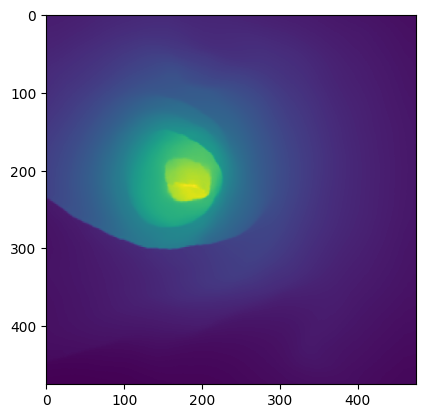

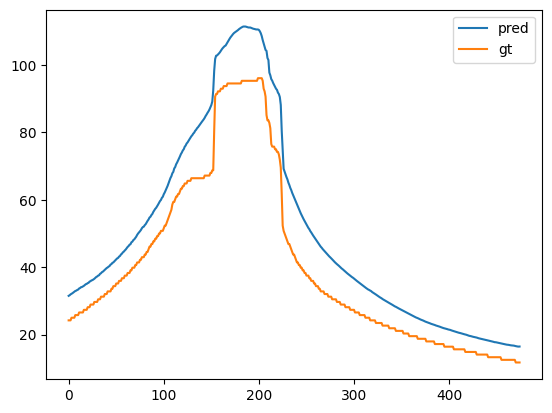

In [27]:
# ratio = np.median(gt) / np.median(pred)
# pred *= ratio
pred = output.copy()

plt.imshow(pred)

plt.figure()
plt.plot(pred[200], label='pred')
plt.plot(gt[200,], label='gt')
plt.legend()


rmse = np.sqrt(np.mean((pred - gt) ** 2))
mae = np.mean(np.abs(pred - gt))
absrel = np.median(np.abs(pred - gt) / (gt+1e-6))

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"ABS REL: {absrel}")

In [3]:
# run.py 的加载方式

DEVICE = "cuda"

model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }

from depth_anything_v2.dpt import DepthAnythingV2
depth_anything = DepthAnythingV2(**{**model_configs['vitl'], 'max_depth': 200})
# depth_anything.load_state_dict(torch.load("/Disk_2/ZanXin/Depth-Anything-V2/metric_depth/123.pth", map_location='cpu'), strict=True)
depth_anything.load_state_dict(torch.load("/Disk_2/ZanXin/Depth-Anything-V2/train_checkpoints/UCL/latest.pth", map_location='cpu')['model'], strict=True)
depth_anything = depth_anything.to(DEVICE).eval()